<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **SpaceX  Falcon 9 first stage Landing Prediction**


# Lab 1: Collecting the data


Estimated time needed: **45** minutes


In this capstone, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, you will collect and make sure the data is in the correct format from an API. The following is an example of a successful and unsuccessfull landings.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/crash.gif)


Most unsuccessful landings are planned. Space X performs a controlled landing in the oceans.


## Objectives


In this lab, you will make a get request to the SpaceX API. You will also do some basic data wrangling and formating.

*   Request to the SpaceX API
*   Clean the requested data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries into the lab


In [1]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the <code>rocket</code> column we would like to learn the booster name.


In [2]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [3]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.


In [4]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

### ADDITION
The API also includes a flag to indicate if a landing was intended (landing_attempt) which will be stores in LandingAttempt

In [5]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])
            LandingAttempt.append(core['landing_attempt'])

### ADDITION:
Let's also define a function to collect the details of the landing pad from the API

In [6]:
def getLandingPadData(data):
    for x in data['LandingPad']:
        if x != None:
            response = requests.get("https://api.spacexdata.com/v4/landpads/"+str(x)).json()
            lpLongitude.append(response['longitude'])
            lpLatitude.append(response['latitude'])
            LandingPadName.append(response['name'])
            LandingPadType.append(response['type'])
        else:
            lpLongitude.append(None)
            lpLatitude.append(None)
            LandingPadName.append(None)
            LandingPadType.append(None)        

Now let's start requesting rocket launch data from SpaceX API with the following URL:


In [7]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [8]:
response = requests.get(spacex_url)
#print(response.text)
#print(response.json())

Check the content of the response


You should see the response contains massive information about SpaceX launches. Next, let's try to discover some more relevant information for this project.


### Task 1: Request and parse the SpaceX launch data using the GET request


To make the requested JSON results more consistent, we will use the following static response object for this project:


In [9]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

We should see that the request was successfull with the 200 status response code


In [10]:
response = requests.get(static_json_url)
response.status_code

200

Now we decode the response content as a Json using <code>.json()</code> and turn it into a Pandas dataframe using <code>.json_normalize()</code>


In [11]:
# Use json_normalize method to convert the json result into a dataframe
data = pd.json_normalize(response.json())

Using the dataframe <code>data</code> print the first 5 rows


In [12]:
# Get the head of the dataframe
data.head(5)

,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,capsules,payloads,launchpad,auto_update,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,True,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,"Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,True,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]",2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,True,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/3d/86/cnu0pan8_o.png,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,True,"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,True,[],4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_succes

You will notice that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number.

We will now use the API again to get information about the launches using the IDs given for each launch. Specifically we will be using columns <code>rocket</code>, <code>payloads</code>, <code>launchpad</code>, and <code>cores</code>.


In [13]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

*   From the <code>rocket</code> we would like to learn the booster name

*   From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

*   From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

*   From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [14]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

LandingAttempt = []

lpLongitude = []
lpLatitude = []
LandingPadName = []
LandingPadType = []


These functions will apply the outputs globally to the above variables. Let's take a looks at <code>BoosterVersion</code> variable. Before we apply  <code>getBoosterVersion</code> the list is empty:


In [15]:
BoosterVersion

[]

Now, let's apply <code> getBoosterVersion</code> function method to get the booster version


In [16]:
# Call getBoosterVersion
getBoosterVersion(data)

the list has now been update


In [17]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

we can apply the rest of the  functions here:


In [18]:
# Call getLaunchSite
getLaunchSite(data)

In [19]:
# Call getPayloadData
getPayloadData(data)

In [20]:
# Call getCoreData
getCoreData(data)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.


In [21]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude,
'LandingAttempt': LandingAttempt
}


Then, we need to create a Pandas data frame from the dictionary launch_dict.


In [22]:
# Create a data frame from the launch_dict
df_launch_data = pd.DataFrame.from_dict(launch_dict)
df_launch_data.tail()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,LandingAttempt
89,102,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058,True
90,103,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1058,-80.603956,28.608058,True
91,104,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058,True
92,105,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857,True
93,106,2020-11-05,Falcon 9,3681.0,MEO,CCSFS SLC 40,True ASDS,1,True,False,True,5e9e3032383ecb6bb234e7ca,5.0,8,B1062,-80.577366,28.561857,True


It would be handy to add details of the landing pad

In [23]:
# Call getLandingPadData
getLandingPadData(df_launch_data)

launch_dict['lpLongitude'] = lpLongitude
launch_dict['lpLatitude'] = lpLatitude
launch_dict['LandingPadName'] = LandingPadName
launch_dict['LandingPadType'] = LandingPadType

df_launch_data = pd.DataFrame.from_dict(launch_dict)

Show the summary of the dataframe


In [24]:
# Show the head of the dataframe
df_launch_data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,LandingAttempt,lpLongitude,lpLatitude,LandingPadName,LandingPadType
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721,False,NaN,NaN,None,None
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721,False,NaN,NaN,None,None
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721,False,NaN,NaN,None,None
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721,False,NaN,NaN,None,None
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,False,NaN,NaN,None,None


### Task 2: Filter the dataframe to only include `Falcon 9` launches


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the <code>BoosterVersion</code> column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called <code>data_falcon9</code>.


In [25]:
# Hint data['BoosterVersion']!='Falcon 1'
data_falcon9 = df_launch_data[df_launch_data.BoosterVersion!='Falcon 1']
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,LandingAttempt,lpLongitude,lpLatitude,LandingPadName,LandingPadType
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,False,NaN,NaN,None,None
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,False,NaN,NaN,None,None
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,False,NaN,NaN,None,None
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,True,NaN,NaN,None,None
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,False,NaN,NaN,None,None


Now that we have removed some values we should reset the FlightNumber column


In [26]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

C:\Users\Fowle\Anaconda\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,LandingAttempt,lpLongitude,lpLatitude,LandingPadName,LandingPadType
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,False,NaN,NaN,None,None
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,False,NaN,NaN,None,None
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,False,NaN,NaN,None,None
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,True,NaN,NaN,None,None
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,False,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058,True,-118.262015,33.729186,OCISLY,ASDS
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1058,-80.603956,28.608058,True,-118.262015,33.729186,OCISLY,ASDS
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058,True,-118.262015,33.729186,OCISLY,ASDS
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857,True,-80.618800,28.410400,JRTI,ASDS


## Data Wrangling


We can see below that some of the rows are missing values in our dataset.


In [27]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
LandingAttempt     0
lpLongitude       26
lpLatitude        26
LandingPadName    26
LandingPadType    26
dtype: int64

Before we can continue we must deal with these missing values. The <code>LandingPad</code> column will retain None values to represent when landing pads were not used.


### Task 3: Dealing with Missing Values


Calculate below the mean for the <code>PayloadMass</code> using the <code>.mean()</code>. Then use the mean and the <code>.replace()</code> function to replace `np.nan` values in the data with the mean you calculated.


The average payload mass was calculated to be 6123.5


C:\Users\Fowle\Anaconda\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


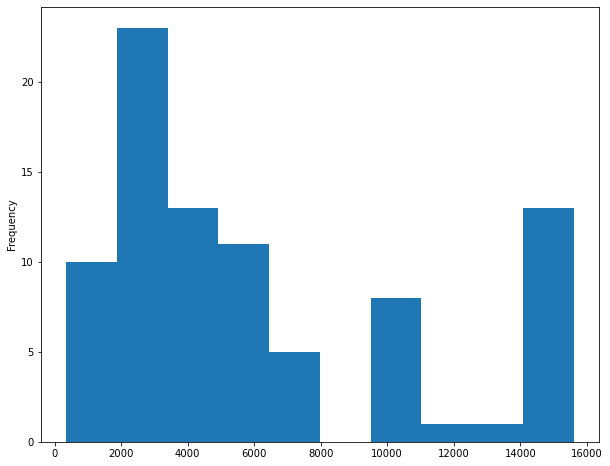

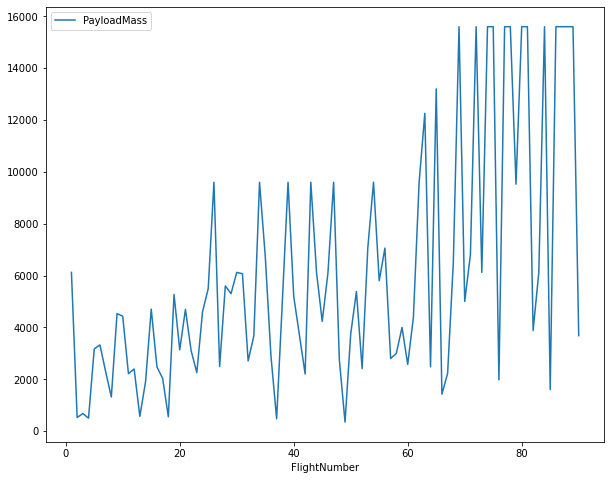

In [28]:
# Visualize the distribution in payload mass
ax = data_falcon9["PayloadMass"].plot.hist(bins=10, figsize=(10, 8))

# Calculate the mean value of PayloadMass column
average_payload_mass = data_falcon9['PayloadMass'].mean()
print(f'The average payload mass was calculated to be {round(average_payload_mass,1)}')

# Replace the np.nan values with its mean value
data_falcon9["PayloadMass"].replace(np.nan, average_payload_mass, inplace=True)
ax2 = data_falcon9.plot(kind='line', x='FlightNumber', y='PayloadMass', figsize=(10, 8))

#### Distribution of payload mass
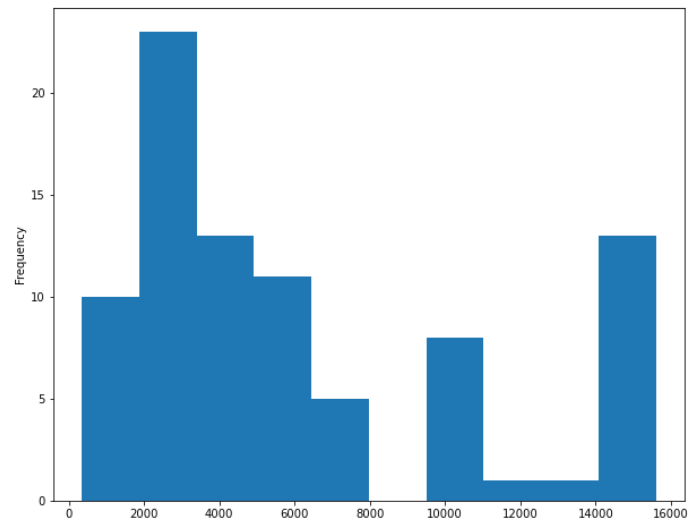

#### Payload Mass vs Flight Number
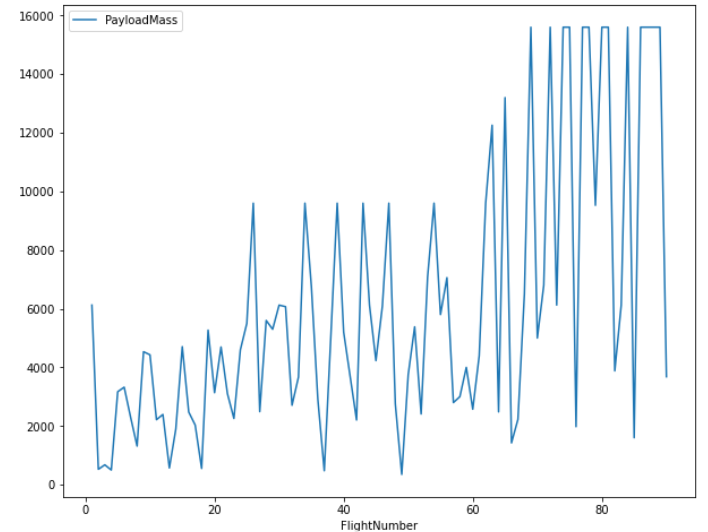

You should see the number of missing values of the <code>PayLoadMass</code> change to zero.


In [29]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
LandingAttempt     0
lpLongitude       26
lpLatitude        26
LandingPadName    26
LandingPadType    26
dtype: int64

Now we should have no missing values in our dataset except for in <code>LandingPad</code>.


We can now export it to a <b>CSV</b> for the next section,but to make the answers consistent, in the next lab we will provide data in a pre-selected date range.


<code>data_falcon9.to_csv('dataset_part\_1.csv', index=False)</code>


In [30]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description                  |
| ----------------- | ------- | ---------- | ----------------------------------- |
| 2020-09-20        | 1.1     | Joseph     | get result each time you run        |
| 2020-09-20        | 1.1     | Azim       | Created Part 1 Lab using SpaceX API |
| 2020-09-20        | 1.0     | Joseph     | Modified Multiple Areas             |


Copyright © 2021 IBM Corporation. All rights reserved.
